In [1]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
import os
import re
from collections import defaultdict 
import numpy as np
import pandas as pd
import json
import nibabel 
from tqdm import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from losses import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets

%autoreload 2

In [2]:
!nvidia-smi

Fri May 27 10:50:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 58%   84C    P2   167W / 250W |   9900MiB / 12211MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [3]:
MAKE_LOGS = False
SAVE_MODEL = False
plt.rcParams['font.size'] = 20

In [4]:
# logdir='./logs/logs_yarkin_data/v2v128-IN_s128_bs1_Dice_lr1e-3_YARKIN-AUG-autocast@20.05.2022-18:36:48/'
# logdir='./logs/logs_yarkin_data/v2v128-IN_s128_bs1_FTLpos-d0.9-g1_lr1e-3_YARKIN-AUG@23.05.2022-23:45:56'

logdir='./logs/logs_nG/v2v128-IN_s128_bs1_GN_SFL-d0.9-g2-lr1e-3_nG-AUG-autocast@04.05.2022-19:53:34/'

In [5]:
val_preds_path = os.path.join(logdir, 'best_val_preds')

In [6]:
def get_latest_weights(logdir, number=None):
    
    checkpoints_path = os.path.join(logdir, 'checkpoints')
    
    if number is None:
        checkpoints_names = os.listdir(checkpoints_path)
        checkpoints_names = sorted(checkpoints_names, key=lambda x: int(re.findall('\d+', x)[0]))
        checkpoint = checkpoints_names[-1]
    else:
        checkpoint = f'weights_{number}.pth'
    
    return os.path.join(checkpoints_path, checkpoint)

In [7]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

In [8]:
label_extractor = lambda x: x.split('_')[1]
reference_preds_dir = '../fcd_data/noel_tl-69-subs-inference/'
reference_preds_labels = set(map(label_extractor, os.listdir(reference_preds_dir)))

best_val_preds_labels = set(best_val_preds.keys())
common_labels = reference_preds_labels.intersection(best_val_preds_labels)

print('common_labels', common_labels)
print('difference', best_val_preds_labels.difference(common_labels))

common_labels {'G324', 'G414', 'n66', 'G258', 'n5', 'n78', 'n11'}
difference {'n15', 'n70'}


In [9]:
reference_masks = {}

for label in tqdm(common_labels):
    reference_results = os.path.join(reference_preds_dir,\
                                        f'FCD_{label}_1',\
                                        'noel_deepFCD_dropoutMC')
    mask_built = True
    mask = []
    for p in os.listdir(reference_results):
        reference_output_path = os.path.join(reference_results, p)
        try:
            mask.append(nibabel.load(reference_output_path).get_fdata() > 0)
        except Exception as e:
            print(e)
            mask_built = False # failed to build mask from predictions
            break
    if mask_built:
        mask = (np.stack(mask, 0).astype(int).sum(0) > 0).astype(int)
        reference_masks[label] = mask

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.46s/it]


In [10]:
mask.shape, len(reference_masks)

((197, 233, 189), 7)

In [11]:
# plt.ioff()
# camera = video_comparison(list(reference_masks.values()),
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [12]:
def trim_label(label_tensor, mask_tensor):

    '''
    mask_tensor - [H,W,D]
    brain_tensor - [N_features, H,W,D]
    label_tensor - [H,W,D]
    
    '''
    X,Y,Z = label_tensor.shape
    
    if mask_tensor is not None:
        X_mask = np.sum(mask_tensor, axis=(1,2)) > 0
        Y_mask = np.sum(mask_tensor, axis=(0,2)) > 0
        Z_mask = np.sum(mask_tensor, axis=(0,1)) > 0

        label_tensor_trim = label_tensor[X_mask][:,Y_mask][:,:,Z_mask]
        mask_tensor_trim = mask_tensor[X_mask][:,Y_mask][:,:,Z_mask]   


    return label_tensor_trim, mask_tensor_trim

reference_val_preds = {}
for label in tqdm(common_labels):
    val_preds_label_path = os.path.join(reference_preds_dir,\
                                        f'FCD_{label}_1',\
                                        'noel_deepFCD_dropoutMC',\
                                        f'FCD_{label}_1_noel_deepFCD_dropoutMC_prob_mean_1.nii.gz')
#                                         'noel_deepFCD_dropoutMC_out_CNN.nii.gz')

    try:
        label_ref = nibabel.load(val_preds_label_path).get_fdata()
        label_ref_trim, mask_trim = trim_label(label_ref, reference_masks[label])
        reference_val_preds[label] = label_ref_trim
    except Exception as e:
        print(e)
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


In [13]:
# plt.ioff()
# camera = video(reference_val_preds['63NS'],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [14]:
# ls -la ../fcd_data/noel_tl-69-subs-inference/FCD_19_1/noel_deepFCD_dropoutMC/

### Load model, setup dataloaders

In [15]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [16]:
# config.dataset.dataset_type = 'fcd'

In [27]:
# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1
DEVICE = 'cpu' # 'cuda:1' #'' # 'cpu'
device = torch.device(DEVICE)


#########
# MODEL #
#########
# if config.model.name == "v2v":
#     model = V2VModel(config).to(device)
# elif config.model.name == "unet3d":
#     model = UnetModel(config).to(device)
    
# model_dict = torch.load(get_latest_weights(logdir, 215))
# print(f'LOADING from {logdir} \n epoch:', model_dict['epoch'])
# model.load_state_dict(model_dict['model_state'])


###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)
print(len(train_dataloader), len(val_dataloader))

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

64 9
val dataloder len:  9 train dataloder len:  64


# Forward pass

In [28]:
SAVE_PREDS = False
USE_REFERENCE = True

if SAVE_PREDS:
    predictions_path = os.path.join(logdir, 'predictions')
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)

In [29]:
dataloader = val_dataloader

In [30]:
# for batch in dataloader:
#     print(batch[0].shape)

In [31]:
# plt.ioff()
# camera = video_comparison([b.numpy()[0,0] for b in batch],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [32]:
# for k,v in reference_val_preds.items():
#     print(k,v.shape)

In [33]:
def dice_var_threshold(label_pred, label_gt, t0=0.1, t1=0.9, num=20):
    scores = []
    thresholds = np.linspace(t0, t1,num)
    for t in thresholds:
        label_pred_t = label_pred.clone()
        label_pred_t[label_pred_t < t] = 0
        label_pred_t[label_pred_t >= t] = 1
        
        scores.append(DiceScoreBinary(label_pred, label_gt))
    return max(scores)

In [34]:
brains = {}
labels_gt = {}
metric_dict = defaultdict(dict)
labels_pred = {}
labels_ref = {}

# model.train(True)
# model.eval()

iterator = enumerate(dataloader)
labels = dataloader.dataset.labels

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
        
        if config.interpolate:
            brain_tensor = F.interpolate(brain_tensor, config.interpolation_size).to(device)
            label_tensor = F.interpolate(label_tensor, config.interpolation_size).to(device)
            mask_tensor = F.interpolate(mask_tensor.type(torch.float), 
                                        config.interpolation_size).type(torch.bool).to(device)
        
        label = labels[iter_i]
        print(f'Label: {label}')
        
         # forward pass
#         label_tensor_predicted = model(brain_tensor) # -> [bs,1,ps,ps,ps]
        
        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...])
        
        if USE_REFERENCE:
            if not label in reference_val_preds.keys():
                continue
            
            label_tensor_ref = torch.tensor(reference_val_preds[label], dtype=torch.float, device=device)
            label_tensor_ref = F.interpolate(label_tensor_ref[None,None,...],
                                             config.interpolation_size)
            
            dice_score_ref = DiceScoreBinary(label_tensor_ref, label_tensor)
            coverage_ref = (label_tensor_ref*label_tensor).sum() / label_tensor.sum()

            metric_dict['coverage_ref'][label] = coverage_ref.item()
            metric_dict['dice_score_ref'][label] = dice_score_ref.item()
            
            print(f'dice_ref: {dice_score_ref}')
            
        
        dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
#         dice_score = dice_var_threshold(label_tensor_predicted, label_tensor)
        
        coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
        
        print(f'dice: {dice_score}')
        
            
        metric_dict['coverage'][label] = coverage.item()
        metric_dict['dice_score'][label] = dice_score.item()
        
        brains[label] = brain_tensor[0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        label_tensor_predicted = label_tensor_predicted[0,0].detach().cpu()
        labels_pred[label] = label_tensor_predicted.numpy()
        labels_ref[label] = label_tensor_ref[0,0].detach().cpu().numpy()
        
        
        if SAVE_PREDS:
            torch.save(label_tensor_predicted, os.path.join(predictions_path, f'{label}'))
        


1it [00:01,  1.96s/it]

Label: n66
dice_ref: 0.008945719338953495
dice: 0.0018305083503946662


2it [00:04,  2.04s/it]

Label: n70


3it [00:06,  2.02s/it]

Label: n78
dice_ref: 0.047524016350507736
dice: 0.0016731037758290768


4it [00:07,  1.85s/it]

Label: n15


5it [00:09,  1.83s/it]

Label: n11
dice_ref: 0.0011434166226536036
dice: 0.0010561681119725108


6it [00:11,  1.82s/it]

Label: n5
dice_ref: 0.010485678911209106
dice: 0.4061914086341858


7it [00:13,  1.81s/it]

Label: G414
dice_ref: 0.12200896441936493
dice: 0.7061561346054077


8it [00:14,  1.83s/it]

Label: G258
dice_ref: 0.021170450374484062
dice: 0.3098839521408081


9it [00:16,  1.85s/it]

Label: G324
dice_ref: 0.012881530448794365
dice: 0.21444572508335114


In [35]:
# for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
#     break

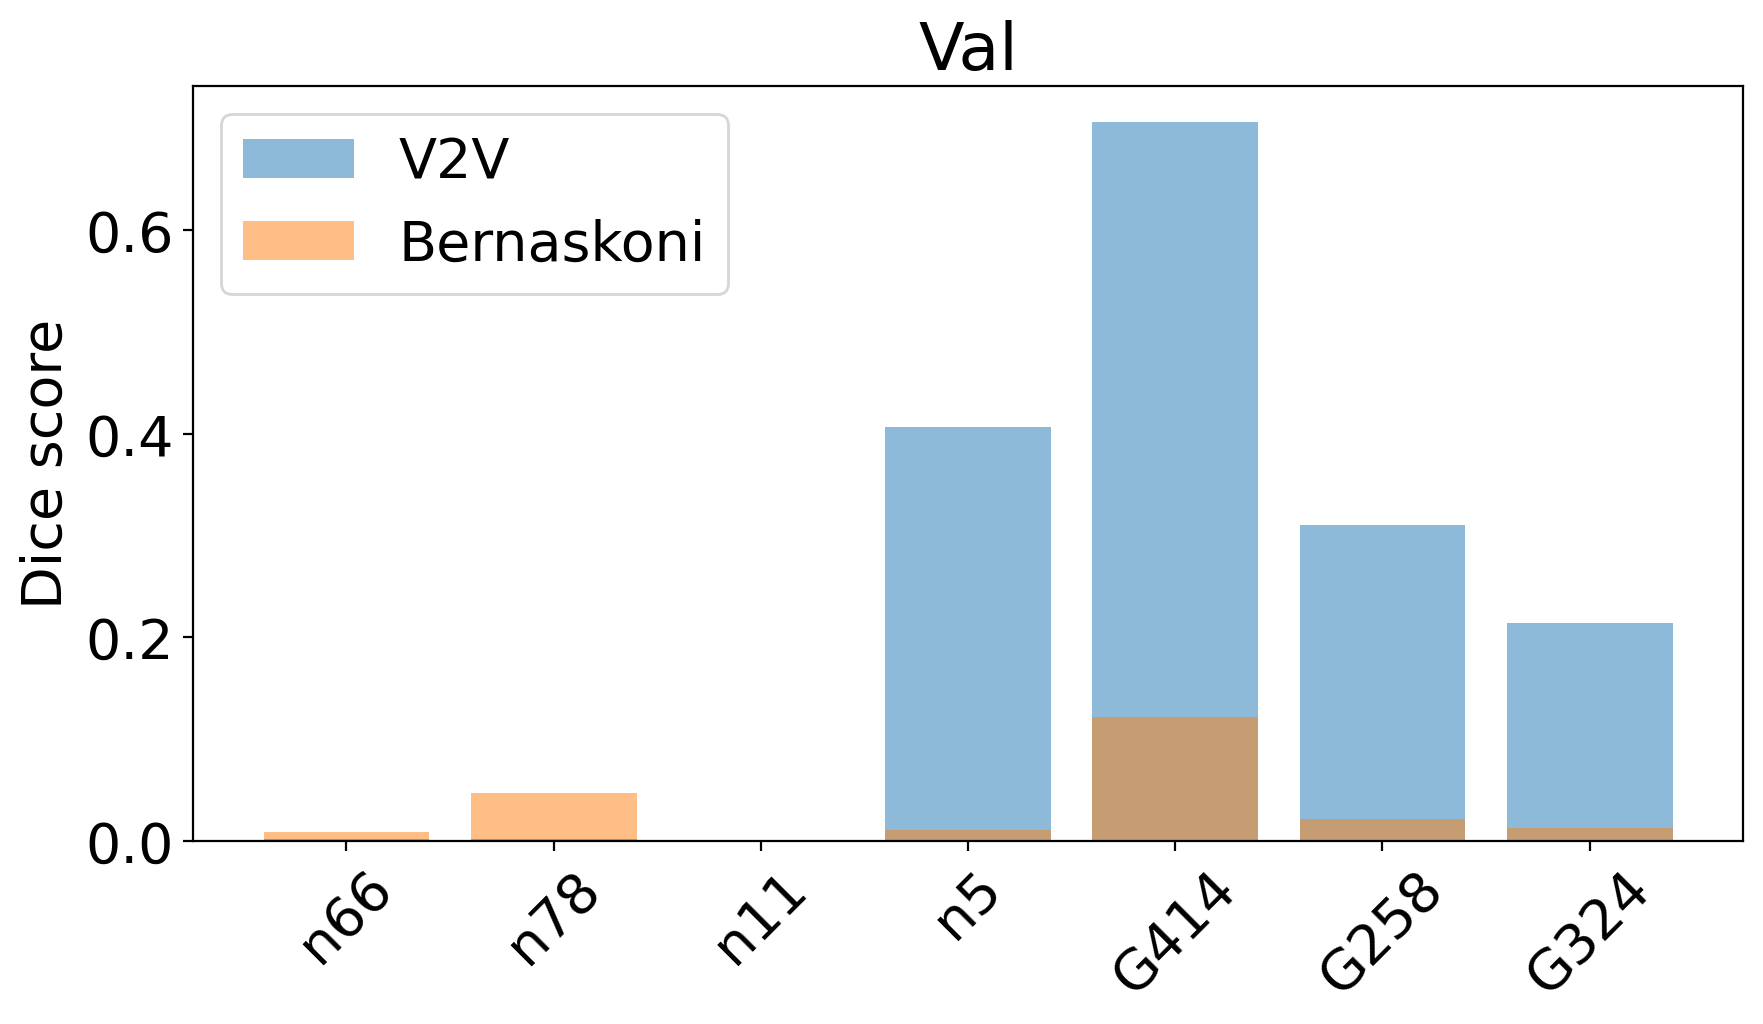

In [36]:
plt.ion()
plt.figure(figsize=(10,5),dpi=200)
plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values(), alpha=0.5, label='V2V')
plt.bar(metric_dict['dice_score_ref'].keys(), metric_dict['dice_score_ref'].values(), alpha=0.5, label='Bernaskoni')
exp_name = logdir.split('/')[1]
plt.title(f'Val')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

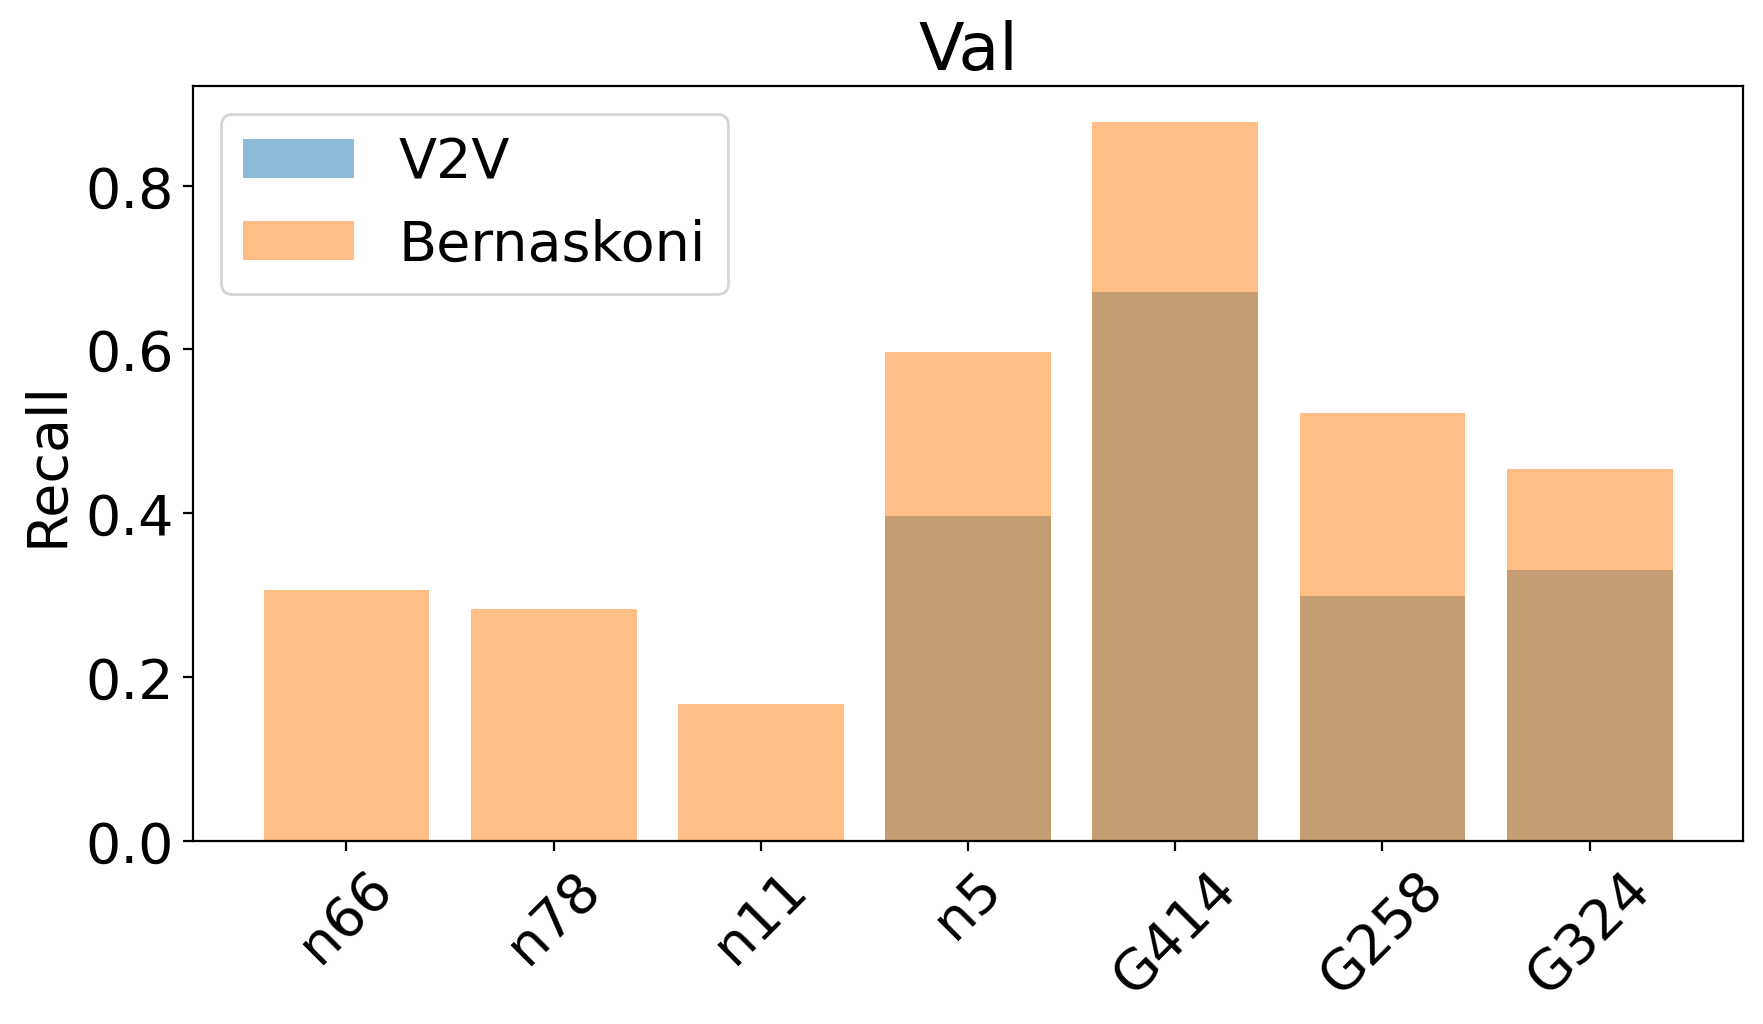

In [37]:
plt.ion()
plt.figure(figsize=(10,5),dpi=200)
plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), alpha=0.5, label='V2V')
plt.bar(metric_dict['coverage_ref'].keys(), metric_dict['coverage_ref'].values(), alpha=0.5, label='Bernaskoni')
exp_name = logdir.split('/')[1]
plt.title(f'Val')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [38]:
# dices = np.array(list(metric_dict['dice_score'].values()))
# labels = np.array(list(metric_dict['dice_score'].keys()))

In [39]:
# plt.ioff()
# camera = video_comparison(brains[label], 
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [40]:
# label = '79NS'

# plt.ioff()
# camera = video_comparison([brains[label][0], brains[label][0], brains[label][0]], 
#                           [labels_gt[label], labels_pred[label], labels_ref[label]], 
#                           titles=['GT', 'V2V', 'Bernasconi'],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [41]:


# val_video_path = os.path.join(logdir, 'val_videos')
# video_path = os.path.join(val_video_path, f'{label}')

# # animation.save(video_path)

In [42]:
# label = 'n66'

# plt.ioff()
# camera = video_comparison([brains[label][5], brains[label][5]], 
#                           [labels_gt[label], labels_pred[label]], 
#                           titles=['GT', 'pred'],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [43]:
image_path = os.path.join(logdir, 'images_val')
if not os.path.exists(image_path):
    os.makedirs(image_path)

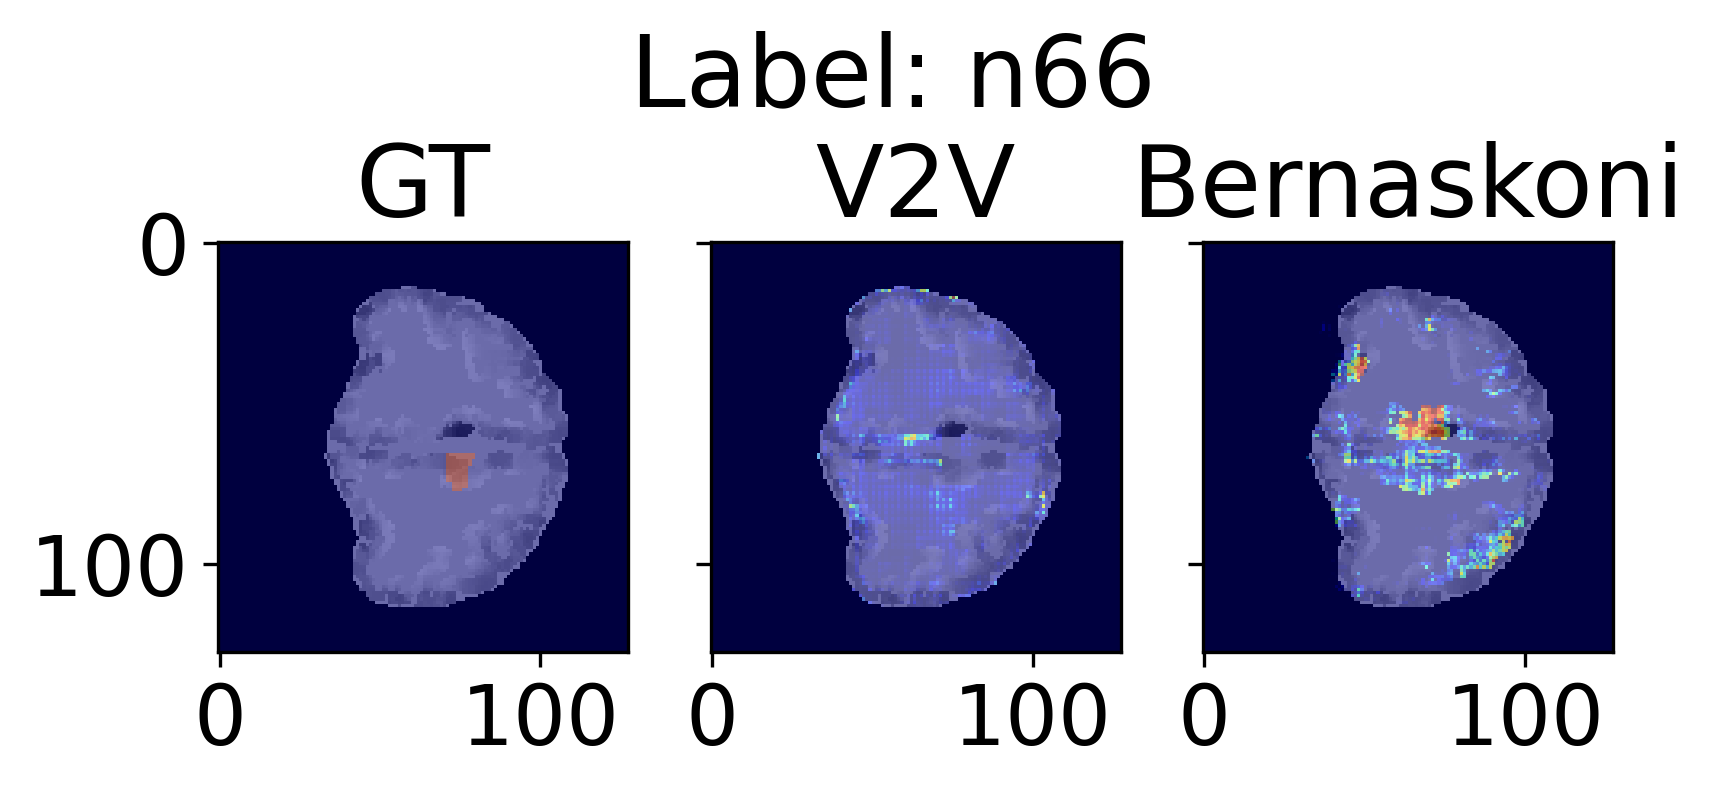

<Figure size 432x288 with 0 Axes>

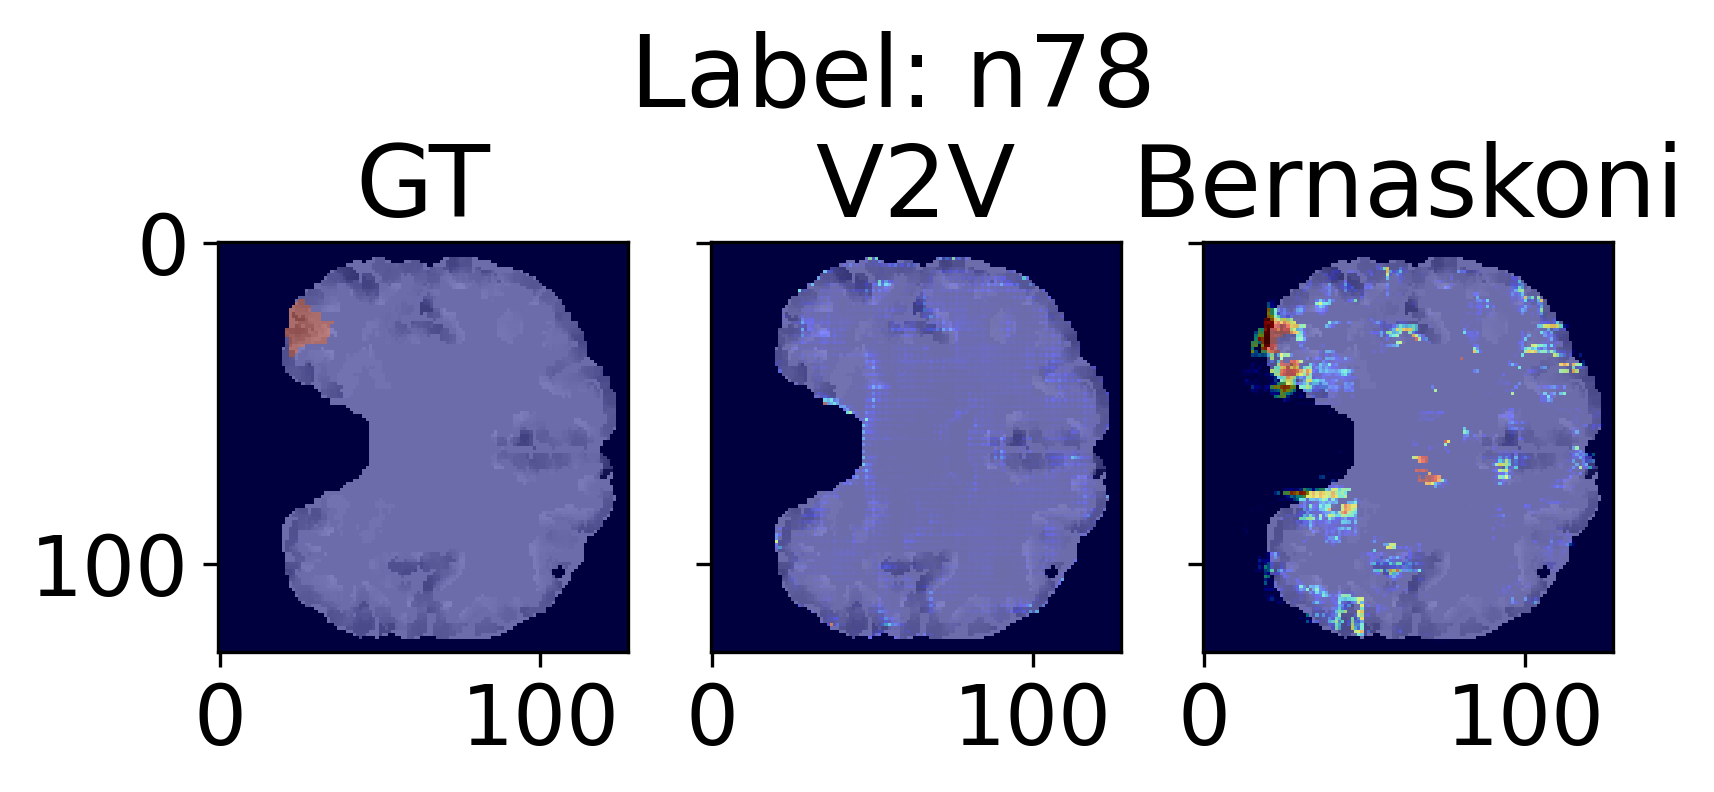

<Figure size 432x288 with 0 Axes>

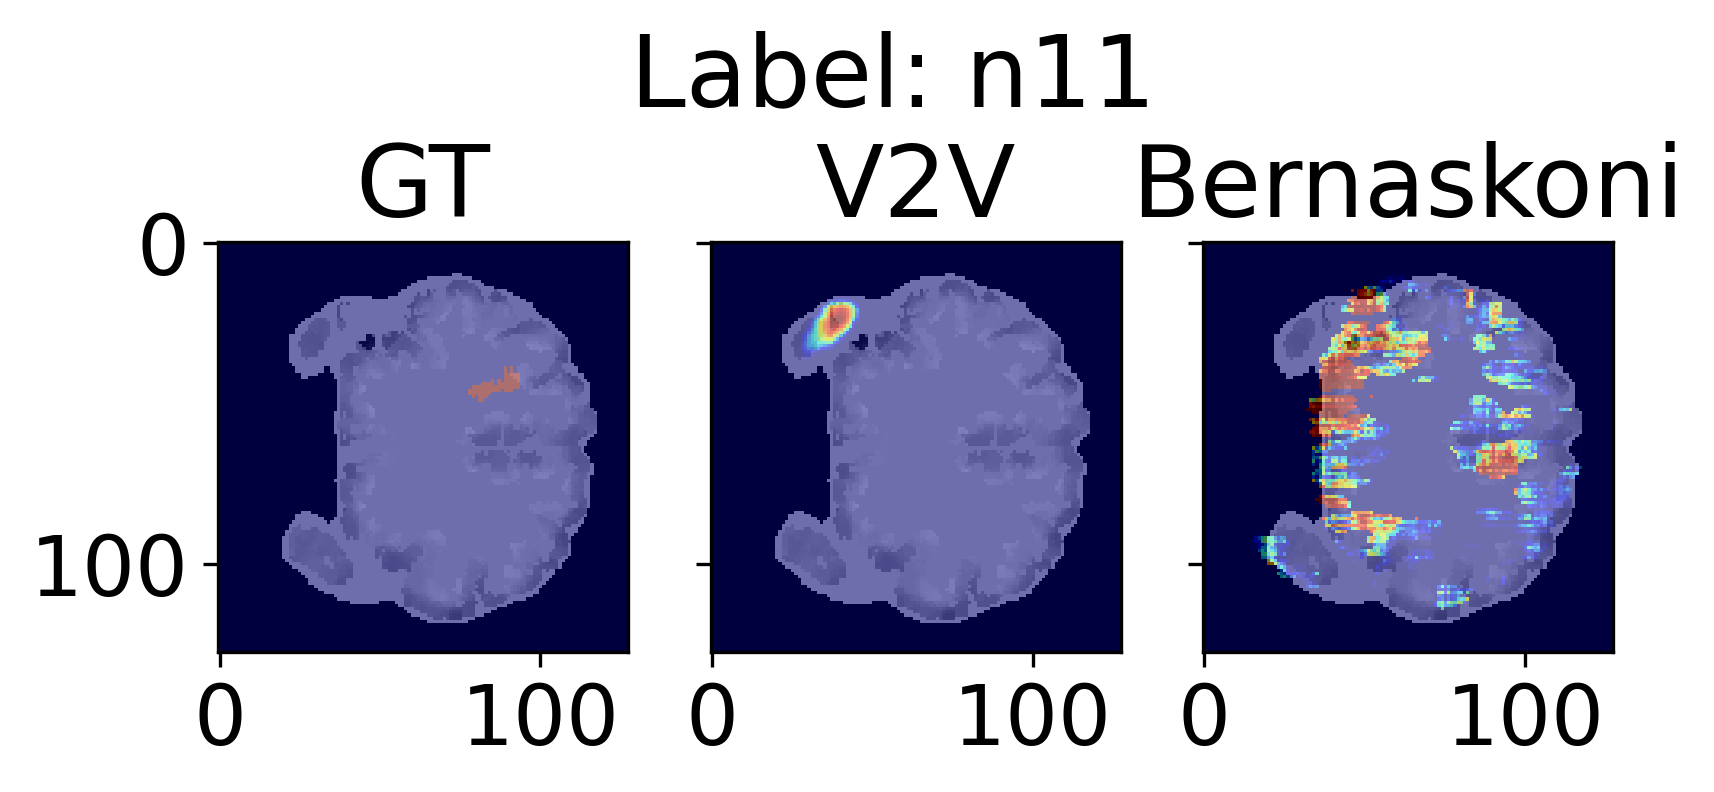

<Figure size 432x288 with 0 Axes>

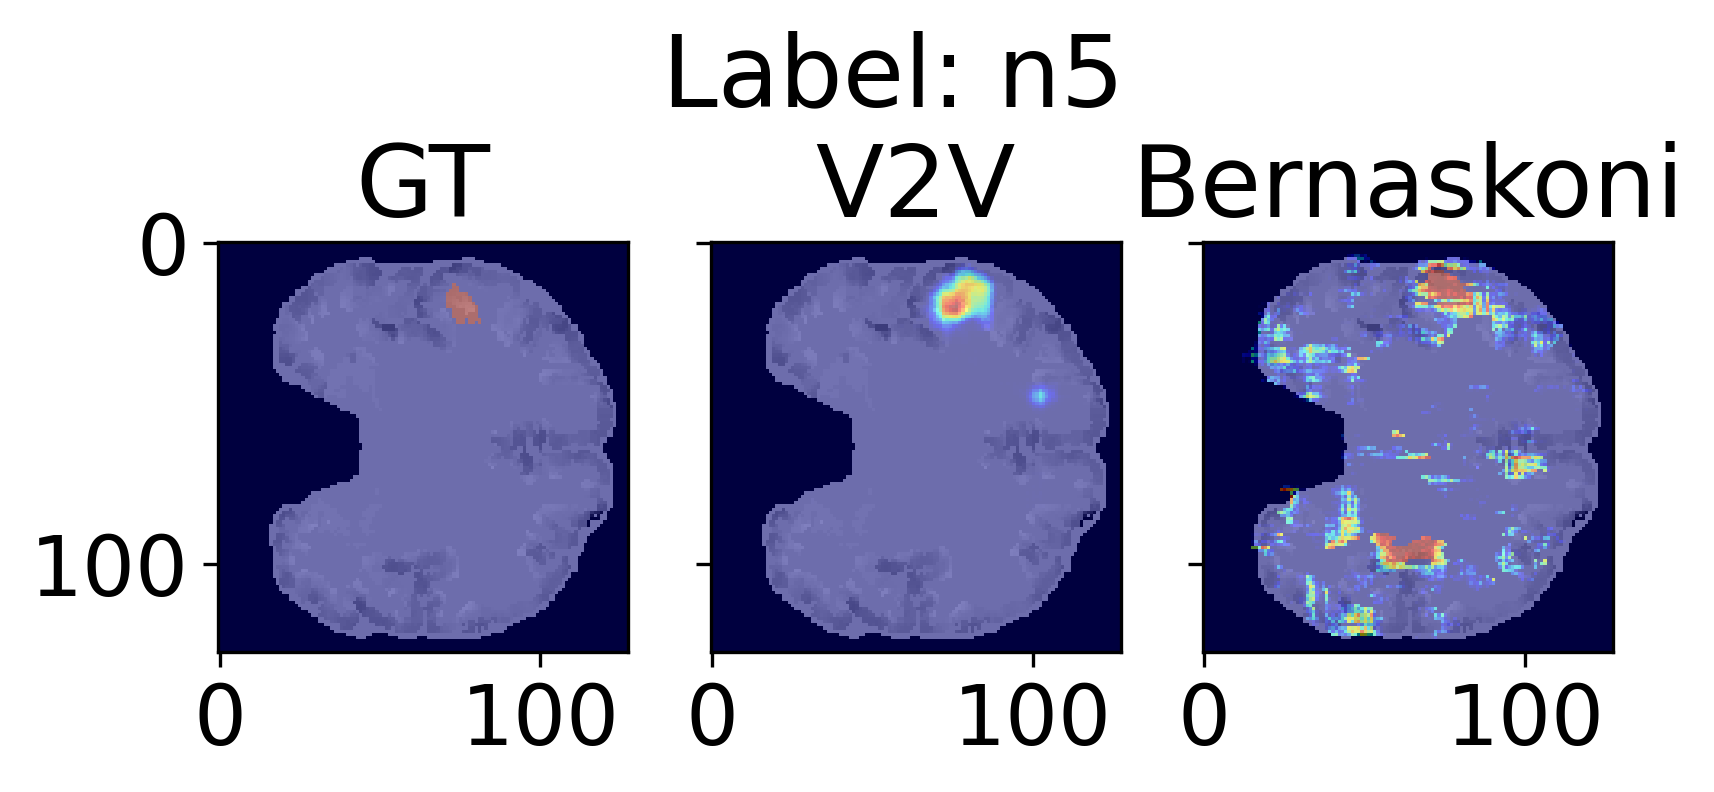

<Figure size 432x288 with 0 Axes>

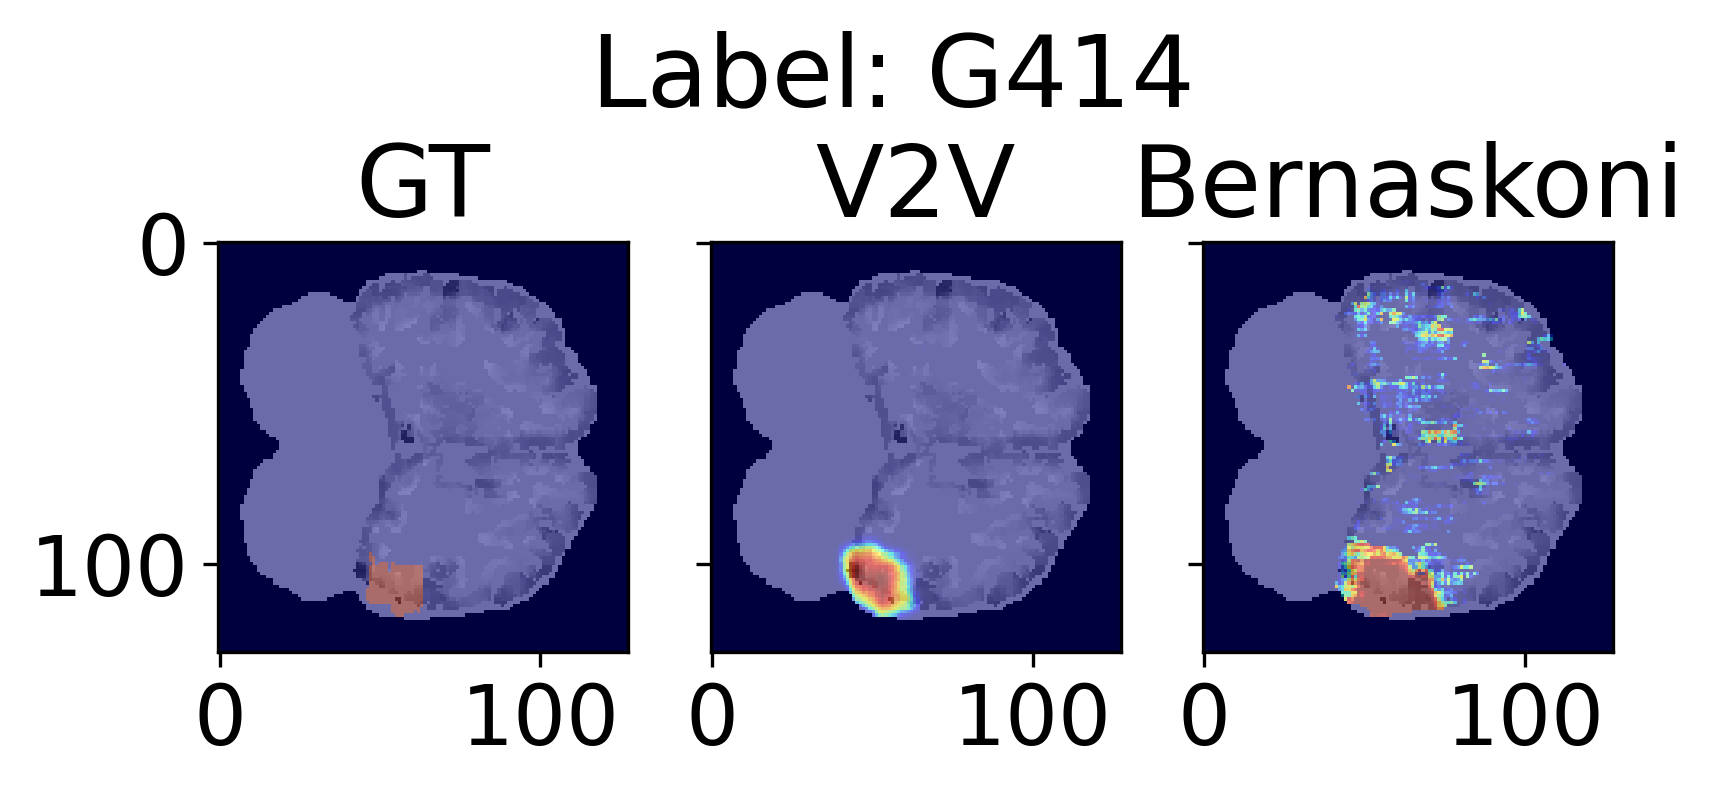

<Figure size 432x288 with 0 Axes>

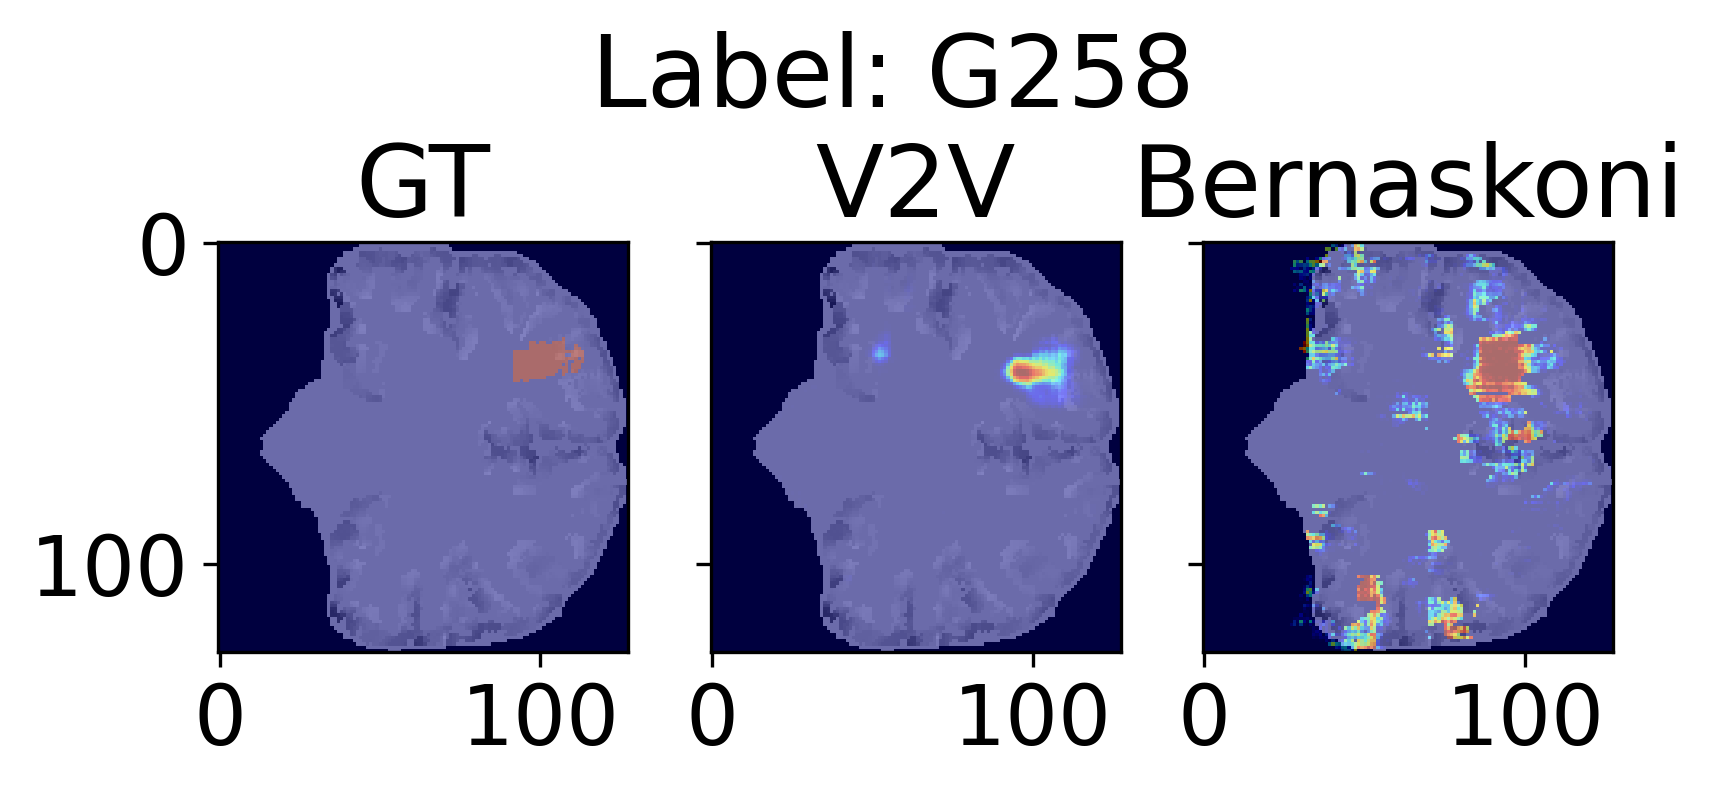

<Figure size 432x288 with 0 Axes>

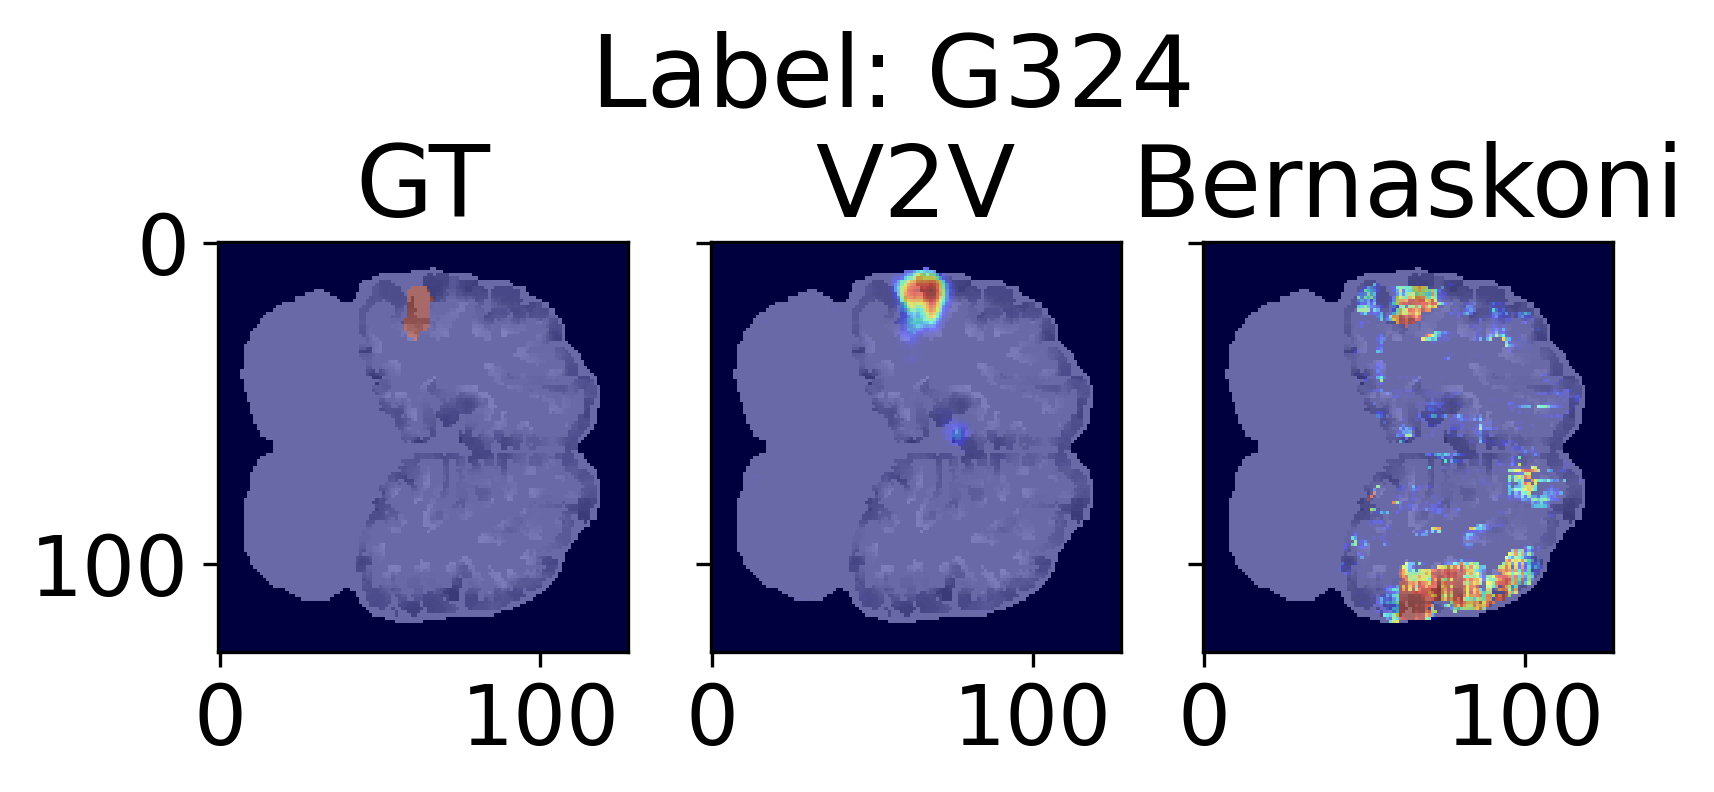

<Figure size 432x288 with 0 Axes>

In [44]:
for label in brains.keys():

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = best_val_preds[label] #labels_pred[label]
    label_ref = labels_ref[label]
    mask = labels_pred[label]

    fig, ax = plt.subplots(1,3, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, 'gray')
    ax[0].imshow(label_gt[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[0].set_title('GT')

    mask_slice = brain[:,y_slice_pos,:]
    ax[1].imshow(brain_slice, 'gray')
    ax[1].imshow(label_pred[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[1].set_title('V2V')
    
    mask_slice = brain[:,y_slice_pos,:]
    ax[2].imshow(brain_slice, 'gray')
    ax[2].imshow(label_ref[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[2].set_title('Bernaskoni')
    
    fig.suptitle(f'Label: {label}', y=.85)

    # plt.colorbar()

    plt.show()
    
    plt.savefig(os.path.join(image_path, f'{label}'))
